<a href="https://www.kaggle.com/code/mohammedmohsen0404/proj22-cv-intel-image-classification?scriptVersionId=193272380" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---
**<center><h1>Intel Image Classification</h1></center>**
<center><h3>Learning ML, DL through 100 Practical Projects</h3></center>

---

This project focuses on the multi-class image classification of natural scenes using deep learning techniques. The dataset, provided by Intel, contains approximately 25,000 images of size 150x150, categorized into six different scene types: buildings, forests, glaciers, mountains, seas, and streets. By leveraging this dataset, the goal is to develop a model that can accurately classify images into these categories, providing insights into scene recognition and classification in computer vision.

# **Import Libraries and Data**
---

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Dropout , Flatten
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from sklearn.metrics import classification_report, confusion_matrix, f1_score

2024-08-20 07:04:43.769540: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 07:04:43.769662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 07:04:43.927836: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip > /dev/null

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
100%|████████████████████████████████████████▊| 345M/346M [00:01<00:00, 380MB/s]
100%|█████████████████████████████████████████| 346M/346M [00:01<00:00, 357MB/s]


# **Data Preparation**
----

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='reflect',
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    'seg_train/seg_train',
    target_size=(255, 255),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'seg_train/seg_train',
    target_size=(255, 255),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    'seg_test/seg_test',
    target_size=(255, 255),
    batch_size=32,
    class_mode='categorical'
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# **Data Exploration**
----

In [6]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Classes present in datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Classes present in datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


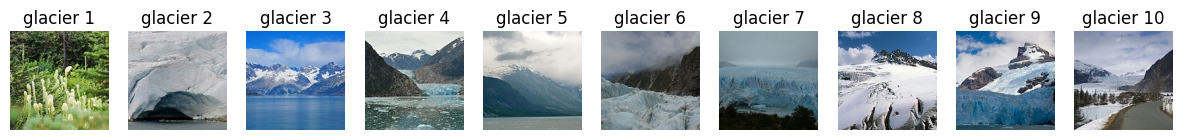

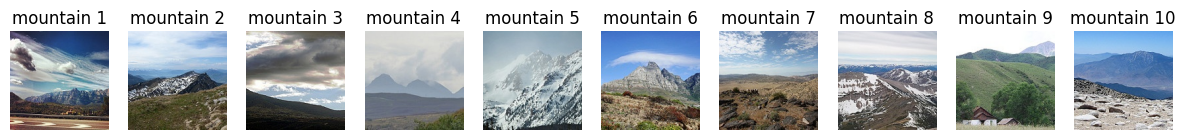

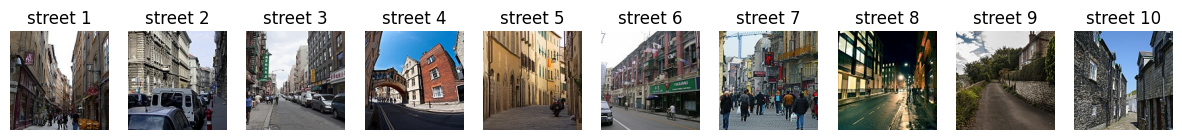

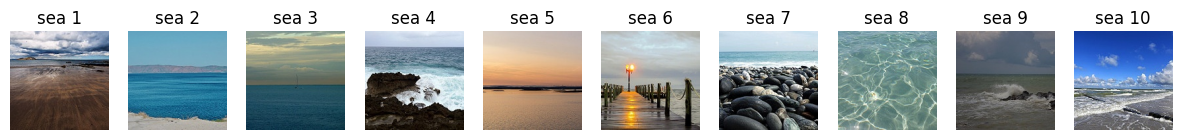

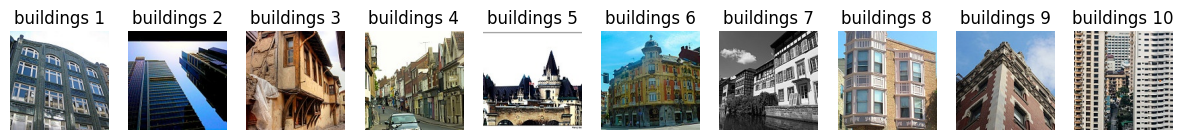

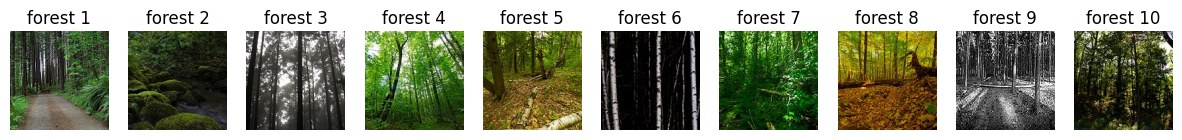

In [7]:
# Function to display images from multiple classes
def display_images_by_class(parent_folder, n_images=10):
    # Get the list of class folders
    class_folders = [f for f in os.listdir(parent_folder) if os.path.isdir(os.path.join(parent_folder, f))]

    for class_folder in class_folders:
        class_path = os.path.join(parent_folder, class_folder)
        images = os.listdir(class_path)[:n_images]
        plt.figure(figsize=(15, 10))
        for i, img_name in enumerate(images):
            img = load_img(os.path.join(class_path, img_name), target_size=(150, 150))
            plt.subplot(1, n_images, i + 1)
            plt.imshow(img)
            plt.title(f"{class_folder} {i+1}")
            plt.axis('off')
        plt.show()

# Path to the parent directory containing class folders
parent_folder = 'seg_train/seg_train'

# Display images for each class in the parent folder
display_images_by_class(parent_folder, n_images=10)

# **Modeling**
----

In [8]:
model = Sequential()

model.add(Conv2D(32,(3,3),padding='same',activation='relu',input_shape = (255,255,3)))
model.add(MaxPooling2D((2,2),strides = 2 ,padding='same' ))

model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D((2,2),strides = 2 ,padding='same' ))

model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D((2,2),strides = 2 ,padding='same' ))

model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D((2,2),strides = 2 ,padding='same' ))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))

model.add(Dense(6,activation='softmax'))

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 255, 255, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,274,854 (8.68 MB)

 Trainable params: 2,274,854 (8.68 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
ES = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
RL = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [12]:
history = model.fit(train_generator,epochs=30,validation_data=val_generator, callbacks=[ES,RL])

Epoch 1/30
  2/351 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.2422 - loss: 1.9671   

I0000 00:00:1724137531.776006     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724137531.798423     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


269/351 ━━━━━━━━━━━━━━━━━━━━ 37s 462ms/step - accuracy: 0.3756 - loss: 1.4955

W0000 00:00:1724137655.515771     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.4072 - loss: 1.4277

W0000 00:00:1724137689.490718     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 216s 561ms/step - accuracy: 0.4076 - loss: 1.4270 - val_accuracy: 0.6334 - val_loss: 0.9418 - learning_rate: 0.0010
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 184s 515ms/step - accuracy: 0.6511 - loss: 0.8945 - val_accuracy: 0.7254 - val_loss: 0.7322 - learning_rate: 0.0010
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 184s 515ms/step - accuracy: 0.7302 - loss: 0.7439 - val_accuracy: 0.7543 - val_loss: 0.6604 - learning_rate: 0.0010
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 184s 517ms/step - accuracy: 0.7632 - loss: 0.6539 - val_accuracy: 0.7960 - val_loss: 0.5774 - learning_rate: 0.0010
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 184s 515ms/step - accuracy: 0.7889 - loss: 0.5890 - val_accuracy: 0.8046 - val_loss: 0.5317 - learning_rate: 0.0010
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 184s 516ms/step - accuracy: 0.8040 - loss: 0.5493 - val_accuracy: 0.8128 - val_loss: 0.5186 - learning_rate: 0.0010
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 185s 518ms/step - accuracy: 0.8105 

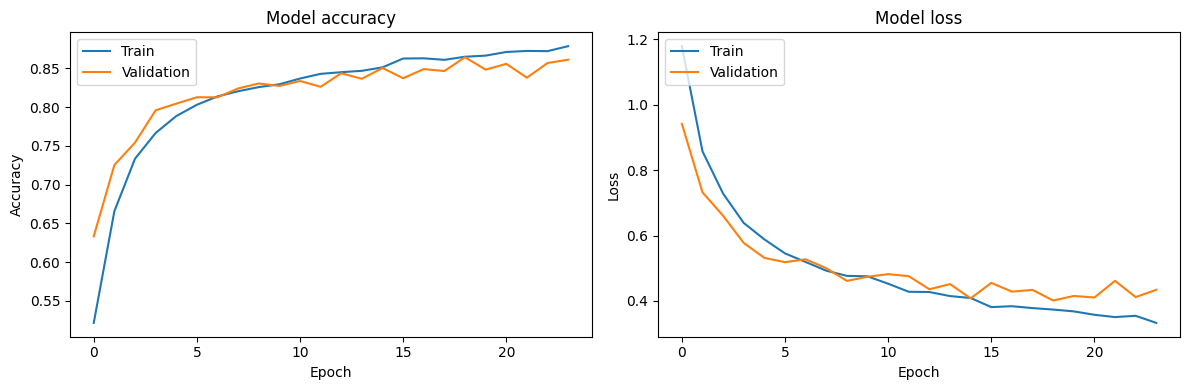

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# **Prediction**
----

In [14]:
loss,acc = model.evaluate(train_generator,batch_size = 32, verbose = 0)
print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

loss,acc = model.evaluate(test_generator,batch_size = 32, verbose = 0)
print('The accuracy of the model for test data is:',acc*100)
print('The Loss of the model for test data is:',loss)

W0000 00:00:1724142105.464365     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


The accuracy of the model for training data is: 88.17453384399414
The Loss of the model for training data is: 0.3346136510372162
The accuracy of the model for test data is: 86.69999837875366
The Loss of the model for test data is: 0.372673898935318


W0000 00:00:1724142112.743648     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 6/94 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step

W0000 00:00:1724142114.861941     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step


W0000 00:00:1724142118.777626     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


F1 Score = 0.16
Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.14      0.14       437
           1       0.15      0.15      0.15       474
           2       0.18      0.17      0.17       553
           3       0.18      0.16      0.17       525
           4       0.17      0.19      0.18       510
           5       0.15      0.14      0.15       501

    accuracy                           0.16      3000
   macro avg       0.16      0.16      0.16      3000
weighted avg       0.16      0.16      0.16      3000



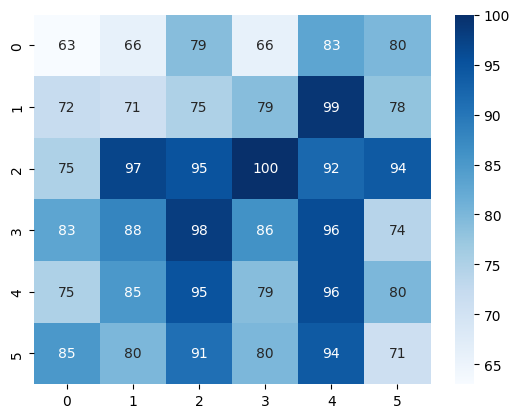

In [15]:
y_pred_prob = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
# y_pred = (y_pred_prob > 0.5).astype(int)  # For binary classification
y_pred = np.argmax(y_pred_prob, axis=1)  # For multi-class classification

y_test = test_generator.classes

f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
print(f'F1 Score = {f1:.2f}')

print(f'Classification Report:\n{classification_report(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

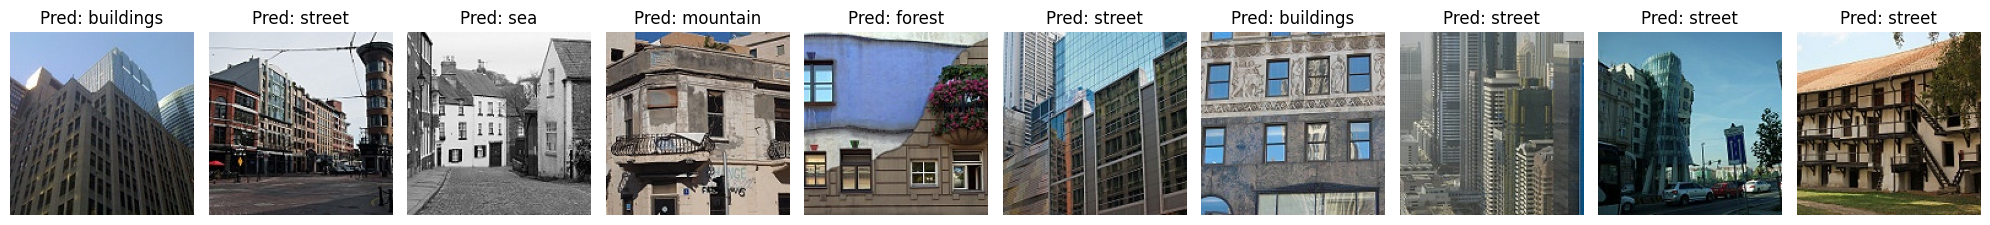

In [16]:
def display_images_with_predictions(generator, y_pred, num_images_to_display=10):
    # Get the class labels
    labels = {v: k for k, v in generator.class_indices.items()}

    # Get the filenames of the images
    filenames = generator.filenames

    # Create a subplot grid
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 4))

    for i in range(num_images_to_display):
        # Construct image path
        image_path = os.path.join(generator.directory, filenames[i])
        image = plt.imread(image_path)

        # Get predicted label
        predicted_label_idx = int(y_pred[i])
        predicted_label = labels[predicted_label_idx]

        # Display the image
        axes[i].imshow(image)
        axes[i].set_title(f"Pred: {predicted_label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming you have a generator and y_pred from your model's predictions
# train_generator = ImageDataGenerator().flow_from_directory(...)  # Assuming this is already created
# y_pred = model.predict(...)  # Assuming this is already done

# Call the function
display_images_with_predictions(train_generator, y_pred, num_images_to_display=10)
